In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

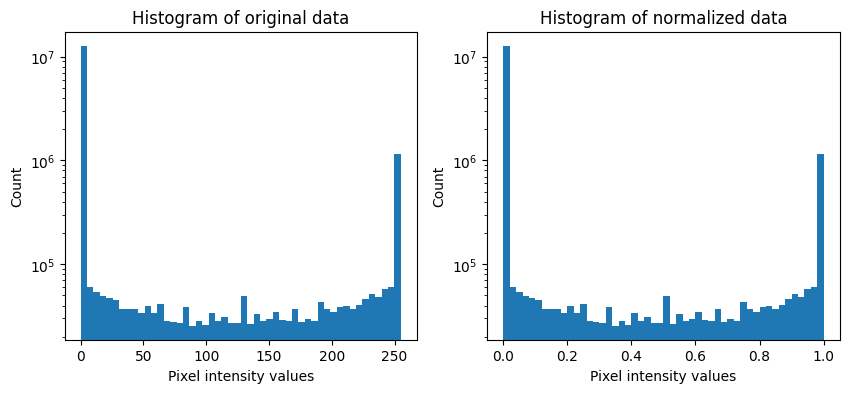

In [ ]:
# normalize the data to a range of [0 1]
dataNorm = (data - np.min(data))/(np.max(data)-np.min(data))

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_yscale('log')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_yscale('log')
ax[1].set_title('Histogram of normalized data')

plt.show()

In [ ]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create ANN model

In [ ]:
## Define Model architecture

class ANNmodel(nn.Module):
  def __init__(self,nUnits,nLayers,output_size):
    super().__init__()

    # create dictionary to store the layers
    self.layers = nn.ModuleDict()
    self.nLayers = nLayers

    # input layer
    self.layers['input'] = nn.Linear(784,nUnits)

    # hidden layers
    for i in range(nLayers):
      self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)

    # output layer
    self.layers['output'] = nn.Linear(nUnits,output_size)

  def forward(self,x):
    # input layer
    x = F.relu(self.layers['input'](x))

    # hidden layers
    for i in range(self.nLayers):
      x = F.relu(self.layers[f'hidden{i}'](x))

    # output layer
    x = self.layers['output'](x)

    return x

In [ ]:
## Function to create the model

def createANNmodel(nUnits,nLayers,output_size):

  model = ANNmodel(nUnits,nLayers,output_size)

  # Loss function
  lossfun = nn.CrossEntropyLoss()

  # Optimizer
  optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

  return model, lossfun, optimizer

In [ ]:
# test the model with one batch
model,lossfun,optimizer = createANNmodel(5,2,10)

X,y = next(iter(train_loader))
yHat = model(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.2947, grad_fn=<NllLossBackward0>)


# Train the model

In [32]:
## Function to train the model

def trainANNmodel(nEpochs=50,nUnits=5,nLayers=2,output_size=10):

  # create the model
  model,lossfun,optimizer = createANNmodel(nUnits,nLayers,output_size)

  # initialize losses and accuracies
  losses    = torch.zeros(nEpochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(nEpochs):

    model.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []

    for X,y in train_loader:

      # forward pass and loss
      yHat = model(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop (training completed for all mini-batches)

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    model.eval()

    # test accuracy
    with torch.no_grad():
      X,y = next(iter(test_loader)) # extract X,y from test dataloader
      yHat = model(X)

      # compare the following really long line of code to the training accuracy lines
      testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

    losses[epochi] = np.mean(batchLoss)

  # end epochs

  # function output
  return trainAcc,testAcc,losses,model

In [33]:
## Test with a fixed numbers of layers and units per layer

trainAcc,testAcc,losses,model = trainANNmodel(nEpochs=50,nUnits=5,nLayers=2,output_size=10)
trainAcc, testAcc

([np.float32(11.304493),
  np.float32(17.699066),
  np.float32(20.940836),
  np.float32(30.782919),
  np.float32(44.456184),
  np.float32(57.189724),
  np.float32(63.94017),
  np.float32(68.88345),
  np.float32(72.84808),
  np.float32(76.36788),
  np.float32(78.71442),
  np.float32(80.415924),
  np.float32(81.32785),
  np.float32(82.54004),
  np.float32(83.00156),
  np.float32(83.43527),
  np.float32(84.09698),
  np.float32(84.26379),
  np.float32(84.59742),
  np.float32(84.71975),
  np.float32(85.22019),
  np.float32(85.281364),
  np.float32(85.42037),
  np.float32(85.52046),
  np.float32(85.82073),
  np.float32(85.876335),
  np.float32(85.87077),
  np.float32(86.43238),
  np.float32(86.4157),
  np.float32(86.771576),
  np.float32(86.84942),
  np.float32(86.87723),
  np.float32(87.288704),
  np.float32(87.38879),
  np.float32(87.461075),
  np.float32(87.50556),
  np.float32(87.77246),
  np.float32(87.9504),
  np.float32(87.83363),
  np.float32(87.983765),
  np.float32(87.94484),
  np.

In [35]:
## Test the model with variable depth (number of layers) and breadth (number of untis)

layers = np.arange(1,4)
units = np.arange(50,300,50)
nEpoch = 50

trainAccs = np.zeros((len(layers),len(units)))
testAccs  = np.zeros((len(layers),len(units)))

for i,nLayers in enumerate(layers):
  for j,nUnits in enumerate(units):
    trainAcc,testAcc,losses,model = trainANNmodel(nEpoch, nUnits, nLayers, 10)
    trainAccs[i,j] = trainAcc[-1]
    testAccs[i,j] = testAcc[-1]

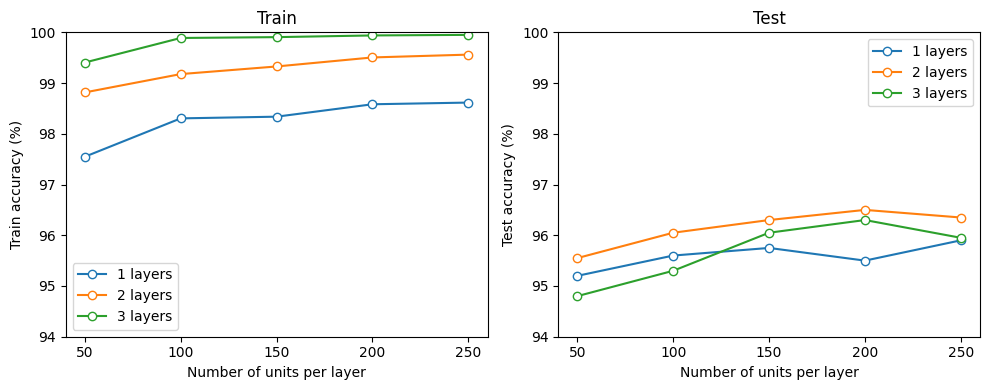

In [51]:
## Plot the performance
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1,2,figsize=(10,4))

# Plot for train accuracies by number of units per layer
for i in range(len(layers)):
  ax[0].plot(units,trainAccs[i,:],'o-', markerfacecolor='w',label=f'{layers[i]} layers')
  ax[1].plot(units,testAccs[i,:],'o-',markerfacecolor='w',label=f'{layers[i]} layers')

for i in range(2):
  ax[i].legend()
  ax[i].set_xlabel('Number of units per layer')
  ax[i].set_ylabel(f'{"Train" if i==0 else "Test"} accuracy (%)')
  ax[i].set_ylim([94,100])
  ax[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
  ax[i].set_title(f'{'Train' if i==0 else 'Test')
  ax[i].set_xticks(units) # Set x-axis ticks to the values in the 'units' array


plt.tight_layout()
plt.show();